In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import tensorflow as tf

from mlxtend.data import loadlocal_mnist
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
#from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import random as rd
import numpy as np
import functools

from sklearn import metrics

%matplotlib inline

In [2]:
32,32,3

(32, 32, 3)

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_data(dataset_name) :
    path_dir_0 = "./Dataset/"
    if dataset_name == "MNIST" :
        path_dir = os.path.join(path_dir_0, "MNIST")
        x_train_path = os.path.join(path_dir,"train-images.idx3-ubyte")
        y_train_path = os.path.join(path_dir,"train-labels.idx1-ubyte")

        x_test_path = os.path.join(path_dir,"t10k-images.idx3-ubyte")
        y_test_path = os.path.join(path_dir,"t10k-labels.idx1-ubyte")
        x_train, y_train = loadlocal_mnist(x_train_path, y_train_path)

        x_test, y_test = loadlocal_mnist(x_test_path, y_test_path)
        
        x_test = (x_test/255).reshape(-1,28,28)
        x_train = (x_train/255).reshape(-1,28,28)
    
    if dataset_name.lower() == "cifar" :
        path_dir = os.path.join(path_dir_0, "cifar-10")
        
        
        train_labels, train_data = [],[]
        
        
        name_batches = [ i for i in os.listdir(path_dir) if "data_batch" in i]
        for batch in name_batches :
            path_batch = os.path.join(path_dir, batch)
            dico = unpickle(path_batch)
            train_labels.append(dico[b"labels"])
            train_data.append(dico[b"data"])
        x_train = np.concatenate(train_data)
        y_train = np.concatenate(train_labels)
        
        path_batch_test = os.path.join(path_dir, "test_batch")
        dico = unpickle(path_batch_test)
        y_test = np.array(dico[b"labels"])
        x_test = np.array(dico[b"data"])
        
            
        x_train = (x_train/255).reshape(-1,32,32,3, order = "F")
        x_test = (x_test/255).reshape(-1,32,32,3, order = "F")
        
        
    return x_train, x_test

x_train, x_test = load_data("cifar") 

In [4]:
print(x_train.shape)

print(x_test.shape)


(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [5]:
dims_data = x_train[0].shape
dims_data

(32, 32, 3)

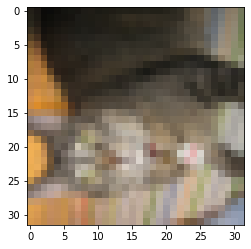

In [6]:
imgplot = plt.imshow(x_test[650])


In [8]:
latent_dim = 121


dim_dense_decoder = functools.reduce(lambda a,b : a*b, dims_data)
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        
        self.encoder = tf.keras.Sequential([layers.Flatten(), layers.Dense(latent_dim, activation='relu'),])
        
        self.decoder = tf.keras.Sequential([layers.Dense(dim_dense_decoder, activation='sigmoid'),layers.Reshape(dims_data)])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class Autoencoder_W_CNN(Model):
    def __init__(self, latent_dim):
        super(Autoencoder_W_CNN, self).__init__()
        self.latent_dim = latent_dim   
        
        self.encoder = tf.keras.Sequential([
                                            
                                            layers.Conv2D(32, (3, 3), activation='relu'),
                                            layers.MaxPooling2D((2, 2)),
                                            layers.Flatten(),
                                            
                                            layers.Dense(latent_dim, activation='relu') ])
        
        size_2D_latent_space = int(latent_dim**0.5)


        self.decoder = tf.keras.Sequential([
                                            
                                            layers.Reshape((size_2D_latent_space,-1,1)),
            
                                            layers.Conv2D(32, (3, 3), activation='relu'),
                                            layers.MaxPooling2D((2, 2)),
                                            layers.Flatten(),
            
                                            layers.Dense(dim_dense_decoder, activation='sigmoid'),
                                            layers.Reshape(dims_data)
                                            ])


    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded    
    
    
    
autoencoder = Autoencoder_W_CNN(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.build((None, 32, 32, 3))
autoencoder.summary()

Model: "autoencoder_w_cnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 121)               872217    
                                                                 
 sequential_3 (Sequential)   (None, 32, 32, 3)         1576256   
                                                                 
Total params: 2,448,473
Trainable params: 2,448,473
Non-trainable params: 0
_________________________________________________________________


In [9]:
hist = autoencoder.fit(x_train, x_train,
                epochs=15,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/15
1563/1563 [==============================] - 78s 49ms/step - loss: 0.0348 - val_loss: 0.0200
Epoch 2/15
1563/1563 [==============================] - 63s 40ms/step - loss: 0.0175 - val_loss: 0.0163
Epoch 3/15
1563/1563 [==============================] - 59s 38ms/step - loss: 0.0159 - val_loss: 0.0154
Epoch 4/15
1563/1563 [==============================] - 53s 34ms/step - loss: 0.0147 - val_loss: 0.0144
Epoch 5/15
1563/1563 [==============================] - 66s 42ms/step - loss: 0.0141 - val_loss: 0.0138
Epoch 6/15
1563/1563 [==============================] - 50s 32ms/step - loss: 0.0136 - val_loss: 0.0133
Epoch 7/15
1563/1563 [==============================] - 57s 37ms/step - loss: 0.0132 - val_loss: 0.0132
Epoch 8/15
1563/1563 [==============================] - 57s 37ms/step - loss: 0.0130 - val_loss: 0.0131
Epoch 9/15
1563/1563 [==============================] - 66s 42ms/step - loss: 0.0129 - val_loss: 0.0129
Epoch 10/15
1563/1563 [==============================] - 58s 37m

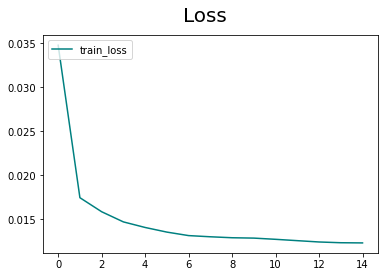

In [10]:
fig =plt.figure()
plt.plot(hist.history['loss'], color ='teal', label ='train_loss')
fig.suptitle('Loss', fontsize =20)
plt.legend(loc ="upper left")
plt.show()

# Test

In [11]:
id_current = 15

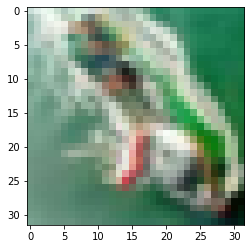

In [12]:
imgplot = plt.imshow(x_test[id_current])

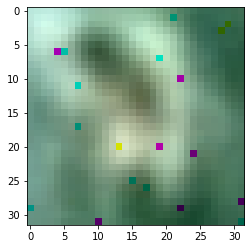

In [13]:
encoded_imgs_test = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs_test).numpy()

imgplot = plt.imshow(decoded_imgs[id_current])

<AxesSubplot:>

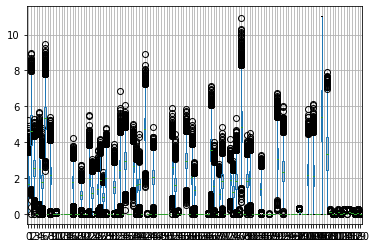

In [14]:
df_tmp = pd.DataFrame(encoded_imgs_test)
df_tmp.boxplot()

# Noise

In [15]:
def random_from_distrib(distrib) :
    #distrib = distrib.reshape(-1)

    n, size = distrib.shape
    
    
    out = np.array([rd.choice(distrib[:,j]) for j in range(size)])
    
    return out

In [16]:

def get_generated_images(model, distrib, count = 1) :
    
    noise_list = []
    for i in range(count) : 
        
        noise_list.append(random_from_distrib(distrib) ) 
        
    noise_array = np.array(noise_list)
    noise_decoded = model.decoder(noise_array).numpy()
    
    return noise_decoded




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

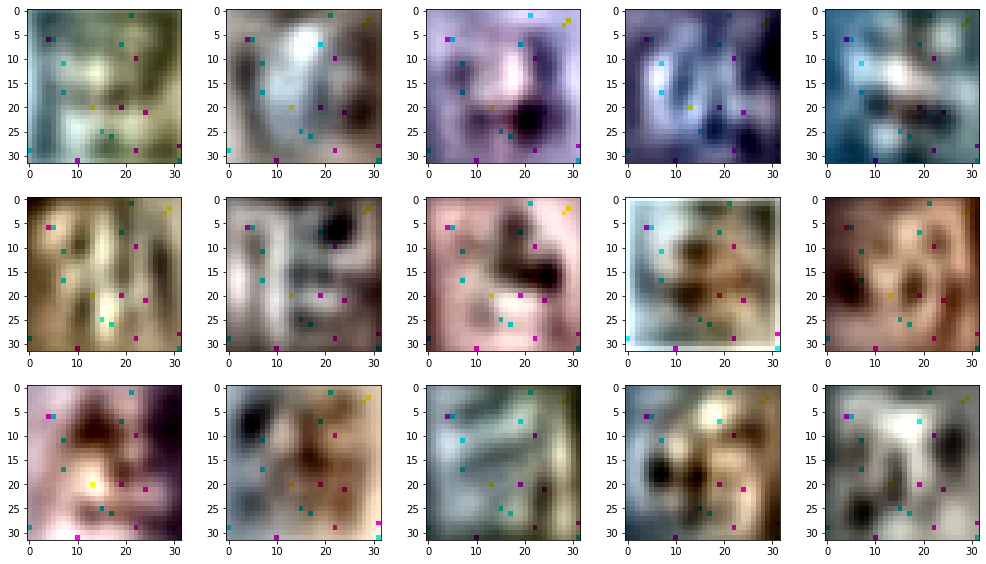

In [22]:
generated_images = get_generated_images(autoencoder,encoded_imgs_test, count = 15)
fig, ax = plt.subplots(3, 5, figsize=(14,8))
fig.tight_layout()

#create subplots
for i in range(5) :
    for j in range(3) :
        ax[j, i].imshow(generated_images[j*5+i])


In [19]:
generated_images[j*5+i].max()

1.0036095